In [1]:
import pandas as pd
import numpy as np
import ta

In [2]:
df = pd.read_csv('1hour.csv')

In [3]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y:%m:%d %H:%M:%S')
df = df.sort_values('timestamp').set_index('timestamp')

In [4]:
df['Target_Close'] = df['close'].shift(-1)
df['Target_Movement'] = (df['close'].shift(-1) > df['close']).astype(int)

In [5]:
FEATURES = ['open', 'high', 'low', 'close', 'volume']
for feature in FEATURES:
    df[f'{feature}_lag1'] = df[feature].shift(1)

In [6]:
df['rsi_lag1'] = ta.momentum.RSIIndicator(close=df['close'], window=14).rsi().shift(1)
df['macd_lag1'] = ta.trend.MACD(close=df['close']).macd().shift(1)

In [7]:
df.dropna(inplace=True)

In [8]:
FEATURE_COLS = [col for col in df.columns if '_lag1' in col]
REG_TARGET_COL = 'Target_Close'
CLS_TARGET_COL = 'Target_Movement'

In [9]:
print("Data prepared successfully!")
print(f"Features being used: {FEATURE_COLS}")
df[FEATURE_COLS + [REG_TARGET_COL, CLS_TARGET_COL]].head()

Data prepared successfully!
Features being used: ['open_lag1', 'high_lag1', 'low_lag1', 'close_lag1', 'volume_lag1', 'rsi_lag1', 'macd_lag1']


,open_lag1,high_lag1,low_lag1,close_lag1,volume_lag1,rsi_lag1,macd_lag1,Target_Close,Target_Movement
timestamp,,,,,,,,,
2017-08-18 06:00:00,4287.92,4340.62,4250.04,4313.56,64.169286,48.837170,-15.670685,4300.25,1
2017-08-18 07:00:00,4313.56,4316.98,4247.75,4279.46,64.235424,44.045575,-16.523767,4282.73,0
2017-08-18 08:00:00,4279.46,4304.67,4270.48,4300.25,69.186804,47.431959,-15.345370,4304.15,1
2017-08-18 09:00:00,4285.00,4320.71,4259.85,4282.73,74.829849,44.962421,-15.644855,4356.31,1
2017-08-18 10:00:00,4265.33,4327.25,4265.33,4304.15,45.653156,48.493266,-13.992488,4340.31,0


MODEL 1

In [10]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
def run_regression_pipeline(df, feature_cols, target_col):
    """
    Runs a full regression analysis pipeline on the given data.
    """
    print("--- 🚀 Starting Regression Pipeline 🚀 ---")

    # Define features (X) and target (y)
    X = df[feature_cols]
    y = df[target_col]

    # Use TimeSeriesSplit for time-series data
    # This ensures we don't use future data to train on past data
    tscv = TimeSeriesSplit(n_splits=5)
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    print(f"Train/Test Split complete. Training set size: {len(X_train)}, Test set size: {len(X_test)}")

    # --- Preprocessing: Scaling ---
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("\n--- ✅ Features Scaled using StandardScaler ---")

    # --- EDA: Best Plots ---
    print("\n--- 📊 Generating Best-Fit Line Plot (Simple Regression) ---")
    # Using 'close_lag1' for simple regression example
    sns.lmplot(x='close_lag1', y=target_col, data=df.iloc[train_index], line_kws={'color': 'red'}, height=6)
    plt.title('Best Fit Line: Lagged Close vs. Target Close')
    plt.xlabel("Previous Hour's Close Price")
    plt.ylabel("Next Hour's Close Price")
    plt.show()

    # --- Model 1: Multiple Linear Regression ---
    print("\n--- 🧠 Training Multiple Linear Regression Model ---")
    mlr_model = LinearRegression()
    mlr_model.fit(X_train_scaled, y_train)
    y_pred_mlr = mlr_model.predict(X_test_scaled)

    # Evaluate MLR Model
    print("Multiple Linear Regression Performance:")
    print(f"  R² Score: {r2_score(y_test, y_pred_mlr):.4f}")
    print(f"  Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred_mlr):.4f}")
    print(f"  Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred_mlr):.4f}")

    # --- Model 2: Polynomial Regression ---
    print("\n--- 🧠 Training Polynomial Regression Model ---")
    r2_scores = []
    degrees = [1, 2, 3] # Test degrees 1, 2, and 3
    print("Finding best polynomial degree...")
    for degree in degrees:
        poly_features = PolynomialFeatures(degree=degree)
        X_train_poly = poly_features.fit_transform(X_train_scaled)

        poly_model = LinearRegression()
        poly_model.fit(X_train_poly, y_train)

        X_test_poly = poly_features.transform(X_test_scaled)
        y_pred_poly = poly_model.predict(X_test_poly)
        score = r2_score(y_test, y_pred_poly)
        r2_scores.append(score)
        print(f"  Degree {degree} -> R² Score: {score:.4f}")

    best_degree = degrees[np.argmax(r2_scores)]
    print(f"\nBest polynomial degree is {best_degree} with R² score of {max(r2_scores):.4f}")
    print("This shows how model complexity affects performance.")

    print("\n--- 🎉 Regression Pipeline Finished! ---")

    # --- User Input Prediction Function ---
    def predict_price(user_input_dict):
        """Takes a dictionary of feature values and returns a price prediction."""
        input_df = pd.DataFrame([user_input_dict])
        input_scaled = scaler.transform(input_df[feature_cols])
        prediction = mlr_model.predict(input_scaled)
        return prediction[0]

    return predict_price

--- 🚀 Starting Regression Pipeline 🚀 ---
Train/Test Split complete. Training set size: 44883, Test set size: 8976

--- ✅ Features Scaled using StandardScaler ---

--- 📊 Generating Best-Fit Line Plot (Simple Regression) ---


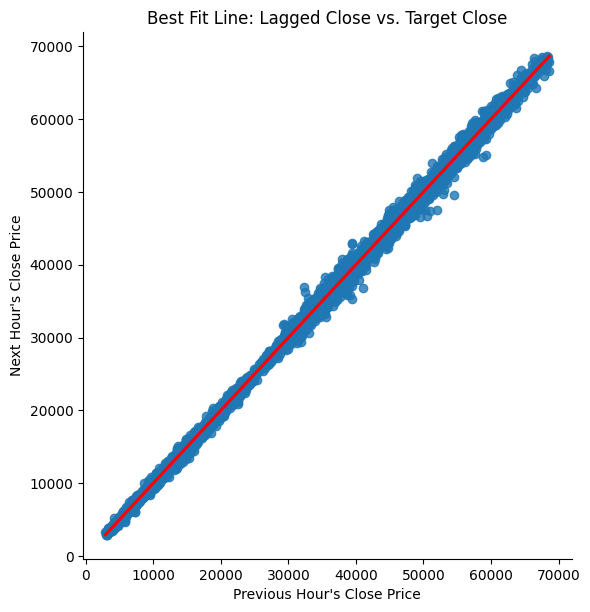


--- 🧠 Training Multiple Linear Regression Model ---
Multiple Linear Regression Performance:
  R² Score: 0.9988
  Mean Absolute Error (MAE): 90.3393
  Mean Squared Error (MSE): 24537.3926

--- 🧠 Training Polynomial Regression Model ---
Finding best polynomial degree...
  Degree 1 -> R² Score: 0.9988
  Degree 2 -> R² Score: 0.9988
  Degree 3 -> R² Score: 0.9987

Best polynomial degree is 1 with R² score of 0.9988
This shows how model complexity affects performance.

--- 🎉 Regression Pipeline Finished! ---


In [12]:
price_predictor = run_regression_pipeline(df, FEATURE_COLS, REG_TARGET_COL)

In [13]:
sample_input = {
    'open_lag1': 27000,
    'high_lag1': 27100,
    'low_lag1': 26900,
    'close_lag1': 27050,
    'volume_lag1': 500,
    'rsi_lag1': 55,
    'macd_lag1': -10
}
predicted_price = price_predictor(sample_input)
print(f"\n\nSample User Input: {sample_input}")
print(f"Predicted Next Hour's Price: ${predicted_price:,.2f}")



Sample User Input: {'open_lag1': 27000, 'high_lag1': 27100, 'low_lag1': 26900, 'close_lag1': 27050, 'volume_lag1': 500, 'rsi_lag1': 55, 'macd_lag1': -10}
Predicted Next Hour's Price: $27,043.51


MODEL 2

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

--- 🚀 Starting Classification Pipeline 🚀 ---
Train/Test Split complete. Training set size: 43087, Test set size: 10772

--- ✅ Features Scaled using StandardScaler ---

--- 📊 Generating EDA Plots ---


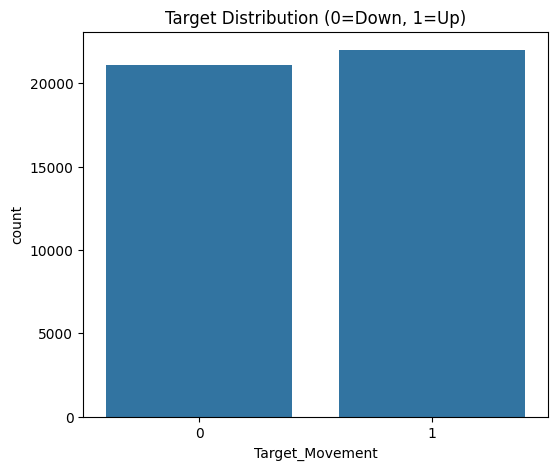


--- 🧠 Training and Evaluating Multiple Classifiers ---

----- K-Nearest Neighbors -----
Accuracy: 49.43%
              precision    recall  f1-score   support

           0       0.49      0.48      0.48      5324
           1       0.50      0.51      0.51      5448

    accuracy                           0.49     10772
   macro avg       0.49      0.49      0.49     10772
weighted avg       0.49      0.49      0.49     10772


----- Gaussian Naive Bayes -----
Accuracy: 50.80%
              precision    recall  f1-score   support

           0       0.50      0.23      0.32      5324
           1       0.51      0.78      0.61      5448

    accuracy                           0.51     10772
   macro avg       0.51      0.50      0.47     10772
weighted avg       0.51      0.51      0.47     10772


----- Decision Tree -----
Accuracy: 50.10%
              precision    recall  f1-score   support

           0       0.50      0.49      0.49      5324
           1       0.51      0.52   

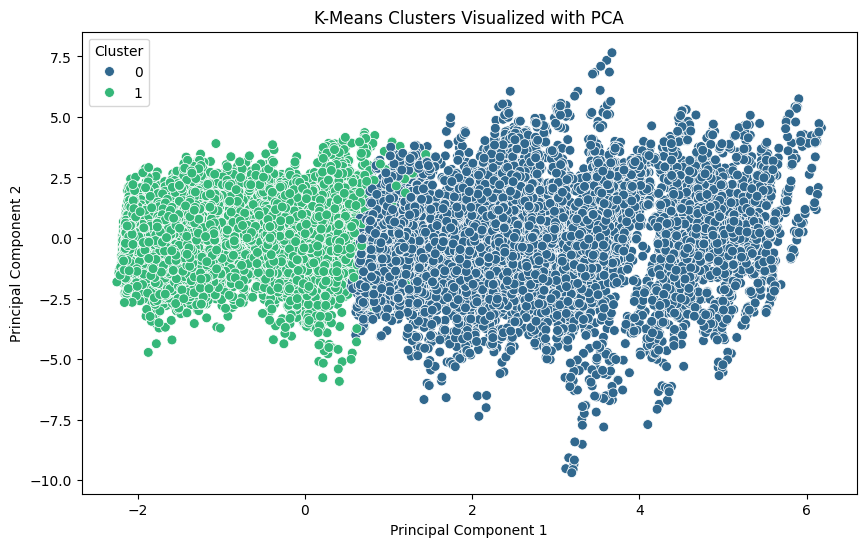


--- 🎉 Classification Pipeline Finished! ---


In [16]:
movement_predictor = run_classification_pipeline(df, FEATURE_COLS, CLS_TARGET_COL)

In [21]:
def run_find_and_tune_pipeline(df, feature_cols, target_col):
    """
    Finds the best-performing model with default parameters, and then
    performs hyperparameter tuning only on that model.
    """
    print("--- 🚀 Starting Optimized Classification Pipeline 🚀 ---")

    X = df[feature_cols]
    y = df[target_col]

    # Stratified split to maintain target distribution
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # --- Step 1: Evaluate all models with their default parameters ---
    print("\n--- STEP 1: Evaluating Models with Normal Parameters ---")

    # Define the models with default settings
    default_models = {
        "K-Nearest Neighbors": KNeighborsClassifier(),
        "Gaussian Naive Bayes": GaussianNB(),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "Support Vector Machine": SVC(random_state=42) # No probability for faster baseline
    }

    # We use a pipeline to ensure the scaler is properly applied every time
    baseline_accuracies = {}
    for name, model in default_models.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', model)
        ])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        baseline_accuracies[name] = accuracy
        print(f"  Accuracy of {name}: {accuracy:.2%}")

    # --- Step 2: Identify the best model from the baseline results ---
    best_model_name = max(baseline_accuracies, key=baseline_accuracies.get)
    print(f"\n--- STEP 2: Best Performing Model is '{best_model_name}' with {baseline_accuracies[best_model_name]:.2%} accuracy ---")

    # --- Step 3: Define parameter grids and perform focused tuning ---
    print(f"\n--- STEP 3: Performing Hyperparameter Tuning for {best_model_name} ---")

    # Full grids for all potential models
    param_grids = {
        "K-Nearest Neighbors": {'classifier__n_neighbors': [3, 5, 7, 9, 11], 'classifier__weights': ['uniform', 'distance']},
        "Gaussian Naive Bayes": {},
        "Decision Tree": {'classifier__max_depth': [10, 20, 30, None], 'classifier__min_samples_leaf': [1, 2, 4]},
        "Random Forest": {'classifier__n_estimators': [100, 200], 'classifier__max_depth': [10, 20, None], 'classifier__min_samples_leaf': [1, 2]},
        "Support Vector Machine": {'classifier__C': [0.1, 1, 10], 'classifier__gamma': ['scale', 'auto'], 'classifier__probability': [True]}
    }

    # Select the model and grid for the winner
    chosen_model = default_models[best_model_name]
    chosen_grid = param_grids[best_model_name]

    # Create the final pipeline for tuning
    final_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', chosen_model)
    ])

    # Perform the Grid Search
    cv = KFold(n_splits=3, shuffle=True, random_state=42)
    grid_search = GridSearchCV(final_pipeline, chosen_grid, cv=cv, n_jobs=-1, scoring='accuracy', verbose=1)
    grid_search.fit(X_train, y_train)

    # --- Step 4: Final Evaluation ---
    print("\n--- STEP 4: Final Evaluation of Tuned Model ---")
    print(f"Best Parameters Found: {grid_search.best_params_}")
    
    # Get the final accuracy on the test set
    final_model = grid_search.best_estimator_
    y_pred_final = final_model.predict(X_test)
    final_accuracy = accuracy_score(y_test, y_pred_final)
    
    print(f"\nInitial Accuracy of {best_model_name}: {baseline_accuracies[best_model_name]:.2%}")
    print(f"**Final Tuned Accuracy of {best_model_name}: {final_accuracy:.2%}**")
    print("\nFinal Classification Report:")
    print(classification_report(y_test, y_pred_final))
    
    print("\n--- 🎉 Optimized Pipeline Finished! ---")
    
    # Return the fully tuned, best-performing model
    return final_model


In [22]:
df = pd.read_csv('1hour.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y:%m:%d %H:%M:%S')
df = df.sort_values('timestamp').set_index('timestamp')
df['Target_Movement'] = (df['close'].shift(-1) > df['close']).astype(int)
FEATURES = ['open', 'high', 'low', 'close', 'volume']
for feature in FEATURES:
    df[f'{feature}_lag1'] = df[feature].shift(1)
df['rsi_lag1'] = ta.momentum.RSIIndicator(close=df['close'], window=14).rsi().shift(1)
df['macd_lag1'] = ta.trend.MACD(close=df['close']).macd().shift(1)
df.dropna(inplace=True)
FEATURE_COLS = [col for col in df.columns if '_lag1' in col]
CLS_TARGET_COL = 'Target_Movement'

In [23]:
final_tuned_model = run_find_and_tune_pipeline(df, FEATURE_COLS, CLS_TARGET_COL)

--- 🚀 Starting Optimized Classification Pipeline 🚀 ---

--- STEP 1: Evaluating Models with Normal Parameters ---
  Accuracy of K-Nearest Neighbors: 49.89%
  Accuracy of Gaussian Naive Bayes: 50.94%
  Accuracy of Decision Tree: 50.17%
  Accuracy of Random Forest: 48.74%
  Accuracy of Support Vector Machine: 52.02%

--- STEP 2: Best Performing Model is 'Support Vector Machine' with 52.02% accuracy ---

--- STEP 3: Performing Hyperparameter Tuning for Support Vector Machine ---
Fitting 3 folds for each of 6 candidates, totalling 18 fits

--- STEP 4: Final Evaluation of Tuned Model ---
Best Parameters Found: {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__probability': True}

Initial Accuracy of Support Vector Machine: 52.02%
**Final Tuned Accuracy of Support Vector Machine: 51.74%**

Final Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.17      0.26      5285
           1       0.52      0.85      0.64      548

In [ ]:
print("\n\n" + "="*50)
print("🤖 PREDICTING WITH FINAL TUNED MODEL 🤖")
print("="*50)

sample_input = {
    'open_lag1': 27000, 'high_lag1': 27100, 'low_lag1': 26900,
    'close_lag1': 27050, 'volume_lag1': 500, 'rsi_lag1': 55, 'macd_lag1': -10
}

In [ ]:
input_df = pd.DataFrame([sample_input])
prediction = final_tuned_model.predict(input_df)
proba = final_tuned_model.predict_proba(input_df)
predicted_move = "UP 🔼" if prediction[0] == 1 else "DOWN 🔽"
confidence = proba[0][prediction[0]]

print(f"\nSample User Input: {sample_input}")
print("-" * 30)
print(f"🧭 Predicted Next Hour's Movement: {predicted_move} with {confidence:.2%} confidence")
